# Juntando as etapas descritas anteriormente em apenas duas partes: Forward Pass e BackPropagation

## Bibliotecas utilizadas:

In [1]:
## Libraries used
import math
import numpy as np
import random
from keras.datasets import mnist
import matplotlib.pyplot as plt

## Definição de parâmetros utilizados pela SNN:

In [2]:
## Definition of a set of parameters that will be used for analysis and code recycling too.
input_params = {}

In [3]:
# Image Patch size
input_params['sample_hsize'] = 28
input_params['sample_vsize'] = 28
input_params['patch_hsize'] = 5
input_params['patch_vsize'] = 5
input_params['stride'] = 1
input_params['patches_set'] = int((input_params['sample_hsize'] - input_params['patch_hsize'])*(input_params['sample_vsize'] - input_params['patch_vsize'])*(1/input_params['stride']))

# Time duration for spikes generation on LIF neurons
input_params['lif_simulation_time'] = 100

# Biological parameters for Encoding and MLP Lif Neurons
input_params['lif_enc_resistance'] = 10
input_params['lif_enc_tao'] = 10
input_params['lif_enc_threshold'] = -50
input_params['lif_enc_rest_potential'] = -70
input_params['lif_enc_start_potential'] = 0
input_params['lif_enc_spike_current'] = 1*(input_params['lif_enc_threshold']-input_params['lif_enc_rest_potential'])/input_params['lif_enc_resistance']

input_params['lif_mlp_resistance'] = 10
input_params['lif_mlp_tao'] = 10
input_params['lif_mlp_threshold'] = -50
input_params['lif_mlp_rest_potential'] = -70
input_params['lif_mlp_start_potential'] = 0
input_params['lif_mlp_spike_current'] = 1*(input_params['lif_mlp_threshold']-input_params['lif_mlp_rest_potential'])/input_params['lif_mlp_resistance']

# Output size
input_params['num_classes'] = 10

# Backpropagation hyperparameters
input_params['learning_rate'] = 0.001
input_params['num_epochs'] = 16
input_params['num_samples'] = 16

## Parte 0: Definição dos valores esperados para impulsos.

In [4]:
###########################################################################################
# A geração dos spike trains esperados para a rede neural, a priori, não é definido por um conjunto de valores fixos.
# Cada classe é representada por um array de 100 posições com valores inteiros, representando cada momento em que um spike foi gerado ou não.
# Para não criar um viés na definição e deixar o mais "randômico" possível, para cada classe esperada (0 a 9), serão geradas 
# sequências de valores aleatórios dentro de intervalos definidos para cada classe:
# Classe 0: Intervalo de valores inteiros de 0 a 9
# Classe 1: Intervalo de valores inteiros de 10 a 19
# Classe 2: Intervalo de valores inteiros de 20 a 29
# Classe 3: Intervalo de valores inteiros de 30 a 39
# Classe 4: Intervalo de valores inteiros de 40 a 49
# Classe 5: Intervalo de valores inteiros de 50 a 59
# Classe 6: Intervalo de valores inteiros de 60 a 69
# Classe 7: Intervalo de valores inteiros de 70 a 79
# Classe 8: Intervalo de valores inteiros de 80 a 89
# Classe 9: Intervalo de valores inteiros de 90 a 99
# Dessa forma a união dos intervalos vai corresponder ao intervalo completo de simulação, que no caso é de 100 passos ("ms")
def spike_interval_generator(number_of_classes=10, simulation_time=100, class_idx=-1):
    interval = []
    for i in range(number_of_classes):
        interval.append((i*int((simulation_time/number_of_classes)),-1 + ((i+1)*int((simulation_time/number_of_classes)))))
        #interval.append((0, simulation_time-1))
    if (class_idx >= 0): #Retorna apenas o intervalo correspondente da classe escolhida
        return interval[class_idx]
    
    return interval

###########################################################################################
## Spike Count Generator for Desired spikes
def spike_count_generator(number_of_classes=10, simulation_time=100, class_idx=-1):
    spike_counts_per_class = np.zeros(number_of_classes)
    
    for i in range(number_of_classes):
        spike_counts_per_class[i] = np.random.randint(2, int((simulation_time/number_of_classes)))
        
    if (class_idx >= 0):#Retorna apenas as contagens correspondentes da classe escolhida
        return spike_counts_per_class[class_idx]
    
    return spike_counts_per_class

###########################################################################################
## Spike Times Generator for Desired spikes
def spike_times_generator(spike_range, spike_count, class_idx):
    desired_spike_train = []
    desired_spike_bin = np.zeros((input_params['num_classes'], input_params['lif_simulation_time']))
    num_classes = input_params['num_classes']
    
    for i in range(num_classes):
        spike_time = random.sample(range(spike_range[i][0], spike_range[i][1]), int(spike_count[i]))
        desired_spike_bin[i][spike_time] = 1
        desired_spike_train.append(np.sort(spike_time))
    
    if (class_idx >= 0):
        return  desired_spike_bin[class_idx]
    
    return desired_spike_bin, np.asarray(desired_spike_train)

###########################################################################################
## Main function to return desired spikes
def get_desired_spikes():
    desired_range = spike_interval_generator(simulation_time=input_params['lif_simulation_time'])
    #desired_range = (0,input_params['lif_simulation_time']-1) # Disconsider different ranges.
    input_params['derired_range'] = desired_range
    desired_count = spike_count_generator(simulation_time=input_params['lif_simulation_time'])
    input_params['desired_count'] = desired_count
    dsp = spike_times_generator(desired_range, desired_count, -1)
    return dsp


## Parte 1: Forward Pass. Corresponde a todas as etapas necessárias para mapear uma amostra no sinal de erro da rede neural.

In [5]:
###########################################################################################
## Image patches extraction
def patches_extraction(image, stride, patch_hsize, patch_vsize):
    patches = []
    num_patches = 0
    ci = 0
    hn = image.shape[0]
    vn = image.shape[1]
    while(ci < hn):
        cj = 0
        while(cj < vn):
            pivot = (ci, cj)
            if(pivot[0]+patch_hsize >= hn or pivot[1]+patch_vsize >= vn):
                cj += stride
            else:
                patch = image[pivot[0]:pivot[0]+patch_hsize, pivot[1]:pivot[1]+patch_vsize]
                patches.append(patch)
                num_patches += 1
                cj += stride
        ci += stride
    #input_params['encoding_layer_neurons_num'] = num_patches
    return np.asarray(patches)

###########################################################################################
## Encoding Synaptic Current
def encoding_synaptic_current(patches, encoding_weights):
    num_patches = input_params['patches_set']
    I_enc = np.zeros(num_patches)
    for p in range(num_patches):
        acc = 0
        for i in range(input_params['patch_hsize']):
            for j in range(input_params['patch_vsize']):
                acc += (patches[p][i][j]*encoding_weights[p][i][j])
        I_enc[p] = acc
    I_enc_norm = (I_enc-input_params['min_enc_input_current'])/(input_params['max_enc_input_current']-input_params['min_enc_input_current'])
    input_params['encoding_current'] = I_enc_norm
    #print(max(synaptic_current))
    return I_enc_norm

###########################################################################################
## MLP Synaptic Current
def mlp_synaptic_current(encoding_spike_train, mlp_weights):
    synaptic_current = []
    for neuron in range(input_params['num_classes']):
        current = 0
        for u in range(input_params['patches_set']):
            for s in range(input_params['lif_simulation_time']):
                current += (encoding_spike_train[u][s] * mlp_weights[neuron][u][s])
        synaptic_current.append(current)
    I_mlp = np.asarray(synaptic_current)
    I_mlp_norm = (I_mlp - input_params['min_mlp_input_current'])/(input_params['max_mlp_input_current']-input_params['min_mlp_input_current'])
    
    input_params['mlp_current'] = I_mlp_norm
    return I_mlp_norm

def mlp_single_synaptic_current(encoding_spike_train, mlp_weights, neuron_idx):
    current = 0
    for u in range(input_params['patches_set']):
        for s in range(input_params['lif_simulation_time']):
            current += (encoding_spike_train[u][s] * mlp_weights[neuron_idx][u][s])/input_params['lif_mlp_spike_current']
    return current

###########################################################################################
## LIF Neuron Potential Dynamics
def lif_activation(R, I, V_rest, V0, tao, t):
    return (V_rest+(R*I))+(V0-V_rest-(R*I))*math.exp((-1*t)/(tao))#(V_rest+(R*I))+(V_rest-(R*I)-V0)*math.exp((-1*t)/(tao))

def lif_interspyke_interval_time(R, I, V_reset, V_th, El, tao):
    log_expr = ((R*I)+El-V_reset)/((R*I)+El-V_th)
    if ((R*I) <= (V_th-El)):
        return 0
    return tao*math.log(log_expr)

def integrate_and_fire_spikes(lif_R, lif_tao, lif_rest_voltage, lif_start_voltage, lif_threshold, I_syn, time_duration):
    spike_train = []
    spike_time = []
    spike_count = 0
    lif_timer = 0
    
    for t in range(time_duration):
        new_voltage = lif_activation(lif_R, I_syn, lif_rest_voltage, lif_start_voltage, lif_tao, lif_timer)
        #print('Membrane potential:', new_voltage)
        if (new_voltage >= lif_threshold):
            spike_train.append(1)
            spike_time.append(t)
            spike_count += 1
            lif_timer = 0
        else:
            spike_train.append(0)
            #spike_time.append(0)
            lif_timer += 1
            
    return np.asarray(spike_train), np.asarray(spike_time), spike_count

###########################################################################################
## Spikes Generation
def spikes_generation(layer_name, input_current, neuron_resistance, time_constant, rest_potential, start_potential, threshold, simulation_time):
    st = []
    st_times = []
    st_count = []

    if(layer_name == 'mlp'):
        iteration_set = input_params['num_classes']
        spike_train_param = 'mlp_spikes'
        spike_time_param  = 'mlp_spike_times'
        spike_count_param = 'mlp_spike_count'
    else: # 'encoding'
        iteration_set = input_params['patches_set']
        spike_train_param = 'encoding_spikes'
        spike_time_param  = 'encoding_spike_times'
        spike_count_param = 'encoding_spike_count'
    
    for neuron in range(iteration_set):
        spikes, spike_times, spike_count = integrate_and_fire_spikes(lif_R=neuron_resistance, 
                                                                        lif_tao=time_constant,
                                                                        lif_rest_voltage=rest_potential, 
                                                                        lif_start_voltage=start_potential, 
                                                                        lif_threshold=threshold, 
                                                                        I_syn=input_current[neuron], 
                                                                        time_duration=simulation_time)
        st.append(spikes)
        st_times.append(spike_times)
        st_count.append(spike_count)

    st = np.asarray(st)
    st_times = np.asarray(st_times)
    st_count = np.asarray(st_count)

    input_params[spike_train_param] = st
    input_params[spike_time_param] = st_times
    input_params[spike_count_param] = st_count
    
    return st, st_times, st_count

###########################################################################################
## Error signal Evaluation
def evaluate_error_signal(desired_spikes, model_spikes):
    return desired_spikes - model_spikes

"""
def evaluate_count_error(desired_count, model_count): 
    return desired_count - model_count

def evaluate_timing_error(desired_times, model_times):
    correct_count = 0
    for spike_time in desired_times:
      correct_count += (model_times == spike_time).sum()
    return len(desired_times) - correct_count
"""
###########################################################################################
## Instantaneous error energy value
def error_energy_value(error_signal):
    sqr_error = 0
    for k in range(input_params['num_classes']):
        for t in range(input_params['lif_simulation_time']):
            sqr_error += (error_signal[k][t])**2
    return 0.5*sqr_error

def partial_error_energy_value(error_signal, class_idx):
    sqr_error = 0
    for t in range(input_params['lif_simulation_time']):
        sqr_error += (error_signal[t])**2
    return sqr_error

###########################################################################################
## Set Maximum/Minimum InputCurrent value according to interspike interval time
def set_current(R, Vth, El, V0, tao, t_isi):
    num = (Vth-El)-(V0-El)*math.exp(-t_isi/tao)
    den = R*(1-math.exp(-t_isi/tao))
    
    return num/den

def set_max_current():
    input_params['max_enc_input_current'] = set_current(R=input_params['lif_enc_resistance'],
                                                    Vth=input_params['lif_enc_threshold'],
                                                    El=input_params['lif_enc_rest_potential'],
                                                    V0=input_params['lif_enc_start_potential'],
                                                    tao=input_params['lif_enc_tao'],
                                                    t_isi=1)
    input_params['max_mlp_input_current'] = set_current(R=input_params['lif_mlp_resistance'],
                                                    Vth=input_params['lif_mlp_threshold'],
                                                    El=input_params['lif_mlp_rest_potential'],
                                                    V0=input_params['lif_mlp_start_potential'],
                                                    tao=input_params['lif_mlp_tao'],
                                                    t_isi=1)

def set_min_current():
    input_params['min_enc_input_current'] = set_current(R=input_params['lif_enc_resistance'],
                                                    Vth=input_params['lif_enc_threshold'],
                                                    El=input_params['lif_enc_rest_potential'],
                                                    V0=input_params['lif_enc_start_potential'],
                                                    tao=input_params['lif_enc_tao'],
                                                    t_isi=input_params['lif_simulation_time'])
    input_params['min_mlp_input_current'] = set_current(R=input_params['lif_mlp_resistance'],
                                                    Vth=input_params['lif_mlp_threshold'],
                                                    El=input_params['lif_mlp_rest_potential'],
                                                    V0=input_params['lif_mlp_start_potential'],
                                                    tao=input_params['lif_mlp_tao'],
                                                    t_isi=input_params['lif_simulation_time'])

### Parte 1.0: Estudo independente do neurônio LIF quando ao comportamento de tipos diferentes de corrente

Count: 3


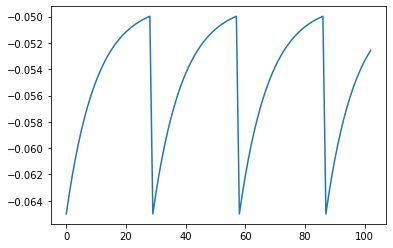

In [6]:

set_max_current()
set_min_current()

# Analise do potencial da membrana
spike_train = []
spike_time = []
spike_count = 0

I_syn = np.zeros(100)
potential = []

I = 0.0000000016

for i in range(100):
    I_syn[i] = I

timer = 0
t = 0
while (t <= 0.1):
    #print(timer)
    vt = lif_activation(10000000, I, -0.065, -0.065, 0.010, timer)
    #print(vt)
    if (vt > -0.050):
       potential.append(vt)
       vt = -0.065
       spike_train.append(1)
       spike_time.append(t)
       timer = 0
       spike_count += 1
    else:
       spike_train.append(0)
       potential.append(vt)
       t += 0.001
       timer += 0.001
    
'''    
for t in range(100):
   vt = lif_activation(10000000, I_syn[t], -0.065, -0.065, 0.010, timer)
   #print(vt)
   if (vt > -0.050):
       potential.append(vt)
       vt = -0.065
       timer = 0
       spike_train.append(1)
       spike_time.append(t)
       spike_count += 1
   else:
       spike_train.append(0)
       potential.append(vt)
       timer += 1
'''
    
potential = np.asarray(potential)
print("Count:", spike_count)
plt.plot(potential)

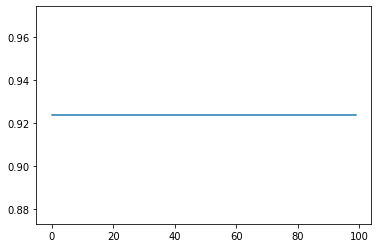

In [7]:
t_isi = np.zeros(100)
I_syn = np.zeros(100)
acc = 0.000000017
for i in range(100):
    I_syn[i] = acc
    #acc += 0.1
    t_isi[i] = lif_interspyke_interval_time(10000000, I_syn[i],-0.065, -0.050, -0.065, 0.010) 
    
    

plt.plot(range(100), t_isi*1000)


### Parte 1.1: Função Forward Pass. 

In [8]:
###########################################################################################
## Mapping Function. It Applies the input into the neural net and returns the output.
def map(input_sample, encoding_weights, mlp_weights):
    patches = patches_extraction(input_sample, 
                                 patch_hsize=input_params['patch_hsize'],
                                 patch_vsize=input_params['patch_vsize'],
                                 stride=input_params['stride'])
    encoding_current = encoding_synaptic_current(patches, encoding_weights)
    encoding_st,_,_ = spikes_generation(layer_name='encoding', input_current=encoding_current,
                                                                          neuron_resistance=input_params['lif_enc_resistance'], 
                                                                          time_constant=input_params['lif_enc_tao'], 
                                                                          rest_potential=input_params['lif_enc_rest_potential'], 
                                                                          start_potential=input_params['lif_enc_start_potential'],
                                                                          threshold=input_params['lif_enc_threshold'], 
                                                                          simulation_time=input_params['lif_simulation_time'])
    mlp_current = mlp_synaptic_current(encoding_st, mlp_weights)
    mlp_st, mlp_st_times, mlp_st_count = spikes_generation(layer_name='mlp', input_current=mlp_current,
                                                                          neuron_resistance=input_params['lif_mlp_resistance'], 
                                                                          time_constant=input_params['lif_mlp_tao'], 
                                                                          rest_potential=input_params['lif_mlp_rest_potential'], 
                                                                          start_potential=input_params['lif_mlp_start_potential'],
                                                                          threshold=input_params['lif_mlp_threshold'], 
                                                                          simulation_time=input_params['lif_simulation_time'])
    return mlp_st, mlp_st_count, mlp_st_times, encoding_current, mlp_current

###########################################################################################
## Forward Pass Main Function. It maps one sample from the set into the error_signal and 
## error energy.
def forwardPass(input_sample, input_sample_label, encoding_weights, mlp_weights):
    mlp_st, _, _, encoding_current, mlp_current = map(input_sample, encoding_weights, mlp_weights)
    
    error_signal = evaluate_error_signal(input_params['desired_spikes'][input_sample_label], mlp_st[input_sample_label])
    return error_signal, encoding_current, mlp_current

## Parte 2: Backward Pass: Backpropagation. Corresponde a todas as etapas que usam o sinal de erro para promover os ajustes de pesos sinápticos

In [9]:
###########################################################################################
## LIF Activation Derivative
def lif_activation_derivative(R, I, V_rest, V0, tao, t):
    return ((V_rest+(R*I)+V0)*math.exp((-1*t)/(tao)))/tao  

###########################################################################################
## MLP Local Gradient Evaluation
def mlp_local_gradient(sample_error_signal, mlp_current):
    local_gradient = np.zeros((input_params['num_classes'], input_params['lif_simulation_time']))
    for k in range(input_params['num_classes']):
        for t in range(input_params['lif_simulation_time']):
            local_gradient[k][t] = (-1)*sample_error_signal[t]*lif_activation_derivative(R     = input_params['lif_mlp_resistance'],
                                                                                        I     = mlp_current[k], 
                                                                                        V_rest= input_params['lif_mlp_rest_potential'], 
                                                                                        V0    = input_params['lif_mlp_start_potential'], 
                                                                                        tao   = input_params['lif_mlp_tao'], 
                                                                                        t     = t)
    return local_gradient

###########################################################################################
## Encoding Local Gradient Evaluation
def enc_local_gradient(mlp_gradients, mlp_weights, encoding_current):
    local_gradient = np.zeros((input_params['patches_set']))
    for e in range(input_params['patches_set']):
        acc = 0
        for k in range(input_params['num_classes']):
            for t in range(input_params['lif_simulation_time']):
                acc += mlp_gradients[k][t]*mlp_weights[k][e][t]
        local_gradient[e] = acc*lif_activation_derivative(R      = input_params['lif_enc_resistance'],
                                                          I      = encoding_current[e], 
                                                          V_rest = input_params['lif_enc_rest_potential'], 
                                                          V0     = input_params['lif_enc_start_potential'], 
                                                          tao    = input_params['lif_enc_tao'], 
                                                          t      = t)
    return local_gradient

###########################################################################################
## Delta Rule for MLP Layer
def mlp_delta_rule(mlp_gradient, mlp_output):
    return input_params['learning_rate']*mlp_gradient*mlp_output

###########################################################################################
## Delta Rule for Encoding Layer
def encoding_delta_rule(encoding_gradient, encoding_output):
    delta = []
    for d in range(input_params['patches_set']):
        delta.append(input_params['learning_rate']*encoding_gradient[d]*encoding_output[d])
    return np.asarray(delta)
###########################################################################################
## Compute New Weights for MLP Layer
def compute_new_mlp_weights(mlp_weights, delta):
    new_weights = []
    for d in range(input_params['patches_set']):
        new_weights.append(mlp_weights[:, d]+delta)
    return np.reshape(np.asarray(new_weights), (input_params['num_classes'], input_params['patches_set'], input_params['lif_simulation_time']))

###########################################################################################
## Compute New Weights for Encoding Layer
def compute_new_enc_weights(enc_weights, delta):
    new_weights = []
    for d in range(input_params['patches_set']):
        new_weights.append(enc_weights[d]+delta[d])
    return np.asarray(new_weights)

### Parte 2.1: Função de Backpropagation

In [10]:
def normalize(data):
    return (data-np.min(data))/(np.max(data)-np.min(data))
###########################################################################################
## Backpropagation function. It uses the error signal and energy to provide new synaptic
## weights adjustments.
def spike_backpropagation(error_signal, encoding_current, mlp_current):
    mlp_local_grad = mlp_local_gradient(error_signal, mlp_current)
    enc_local_grad = enc_local_gradient(mlp_local_grad, input_params['mlp_weights'], encoding_current)
    mlp_delta = mlp_delta_rule(mlp_local_grad, input_params['mlp_spikes'])
    enc_delta = encoding_delta_rule(enc_local_grad, input_params['encoding_spike_count'])
    new_mlp_W = compute_new_mlp_weights(input_params['mlp_weights'], mlp_delta)
    new_enc_W = compute_new_enc_weights(input_params['encoding_weights'], enc_delta)

    norm_mlp_W = normalize(new_mlp_W)
    norm_enc_W = normalize(new_enc_W)
    
    return norm_mlp_W, norm_enc_W

## Parte 3: Algoritmo de Treinamento da Rede Neural por Impulsos

In [11]:
###########################################################################################
## Fitting function
def fit(sample_set):
    W_enc = np.random.uniform(0, 1, (input_params['patches_set'], input_params['patch_hsize'], input_params['patch_vsize']))
    input_params['encoding_weights'] = W_enc

    W_mlp = np.random.uniform(0, 1, (input_params['num_classes'], input_params['patches_set'], input_params['lif_simulation_time']))
    input_params['mlp_weights'] = W_mlp

    training_error = np.zeros(input_params['num_epochs'])
    
    for epoch_count in range(input_params['num_epochs']):
        sse_sum = 0
        for sample_count in range(input_params['num_samples']):
            err_sum = 0
            for class_count in range(input_params['num_classes']):
            
                error_signal, I_enc, I_mlp = forwardPass(input_sample=sample_set[class_count, sample_count], 
                                                            input_sample_label=class_count,
                                                            encoding_weights=input_params['encoding_weights'], 
                                                            mlp_weights=input_params['mlp_weights'])
                mw, ew = spike_backpropagation(error_signal, I_enc, I_mlp)
                input_params['mlp_weights'] = mw
                input_params['encoding_weights'] = ew
                err_sum += partial_error_energy_value(error_signal, class_count)
            sse_sum += 0.5*err_sum
        mse = sse_sum/(input_params['patches_set']*input_params['num_classes']*input_params['num_samples'])
        print("MSE - Epoch {}:{}".format(epoch_count, mse))
        training_error[epoch_count] = mse
    return training_error

def forward_backward (class_num, sample_num, sample_set, err_sum):
    error_signal, I_enc, I_mlp = forwardPass(input_sample=sample_set[class_num, sample_num], 
                                             input_sample_label=class_num,
                                             encoding_weights=input_params['encoding_weights'], 
                                             mlp_weights=input_params['mlp_weights'])
    mw, ew = spike_backpropagation(error_signal, I_enc, I_mlp)
    input_params['encoding_weights'] = ew
    input_params['mlp_weights'] = mw
    error = partial_error_energy_value(error_signal, class_num)
    err_sum += error

# Execução do bloco principal do algoritmo de treinamento:

## Extração das Amostras de entrada para treinamento da Rede Neural

In [12]:
## Extração das amostras
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train/255
x_test = x_test/255
# Escolhe um range aleatório de labels de acordo com sua quantidade
labels = random.sample(range(0,input_params['num_classes']), input_params['num_classes'])
samples = []
test_samples = []
print(np.sort(labels))
# Monta um array com samples por label
for label in labels:
    samples_per_label = x_train[np.where(y_train == label)]
    test_samples_per_label = x_test[np.where(y_test == label)]

    num_samples_per_label = samples_per_label.shape[0]
    num_test_samples_per_label = test_samples_per_label.shape[0]

    samples_idx = random.sample(range(0, num_samples_per_label-1), input_params['num_samples'])
    test_samples_idx = random.sample(range(0, num_test_samples_per_label-1), input_params['num_samples'])
    
    samples.append(samples_per_label[samples_idx])
    test_samples.append(test_samples_per_label[test_samples_idx])

samples = np.asarray(samples)
test_samples = np.asarray(test_samples)

[0 1 2 3 4 5 6 7 8 9]


In [13]:
test_samples.shape

(10, 16, 28, 28)

## Aplicação de um Ruído nas imagens, para aumentar a robustez do modelo de classificação:

In [14]:
def img_noise(sample, prob):
    noisy_img = np.zeros(sample.shape)
    noisy_samples = np.zeros(sample.shape)
    threshold = 1 - prob
    for i in range(sample.shape[0]):
      for j in range(sample.shape[1]):
        rdn = random.random()
        if (rdn < prob):
            noisy_img[i][j] = 0
        elif (rdn > threshold):
            noisy_img[i][j] = 1
            noisy_samples[i][j] = 1
        else:
            noisy_img[i][j] = sample[i][j]
    return noisy_img

In [15]:
noise_probability = 0.05

for c in range(input_params['num_classes']):
  for s in range(input_params['num_samples']):
    samples[c][s] = img_noise(samples[c][s], noise_probability)
    

## Geração dos Impulsos Desejados para a(s) classe(s) definida(s):

In [16]:
# Expected Values for Spikes for classes
desired_range = spike_interval_generator(simulation_time=input_params['lif_simulation_time'])
desired_count = spike_count_generator(simulation_time=input_params['lif_simulation_time'])
dsb, dst = spike_times_generator(desired_range, desired_count, -1)
input_params['desired_spikes'] = dsb[np.sort(labels)]
input_params['desired_times'] = dst[np.sort(labels)]
input_params['desired_count'] = desired_count

c:\Users\dmene\Anaconda3\envs\snn-pso\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [17]:
print("Intervalo e Spike Train Esperado por Classe:")
for i in range(input_params['num_classes']):
  print("Classe "+str(i)+ ":", desired_range[i], dst[i])

Intervalo e Spike Train Esperado por Classe:
Classe 0: (0, 9) [2 4 7]
Classe 1: (10, 19) [10 13 14 16 17 18]
Classe 2: (20, 29) [20 25 27 28]
Classe 3: (30, 39) [30 31 32 33 34 36 37 38]
Classe 4: (40, 49) [40 41 42 43 45 47]
Classe 5: (50, 59) [50 53 55 57 58]
Classe 6: (60, 69) [61 62 63 68]
Classe 7: (70, 79) [70 71 72 73 74 75 76 78]
Classe 8: (80, 89) [81 82 83 85 87 88]
Classe 9: (90, 99) [92 94]


## Treinamento da Rede Neural:

MSE - Epoch 0:0.08960302457466919
MSE - Epoch 1:0.08960302457466919
MSE - Epoch 2:0.08960302457466919
MSE - Epoch 3:0.08960302457466919
MSE - Epoch 4:0.08960302457466919
MSE - Epoch 5:0.08960302457466919
MSE - Epoch 6:0.08960302457466919
MSE - Epoch 7:0.08960302457466919
MSE - Epoch 8:0.08960302457466919
MSE - Epoch 9:0.08960302457466919
MSE - Epoch 10:0.08960302457466919
MSE - Epoch 11:0.08960302457466919
MSE - Epoch 12:0.08960302457466919
MSE - Epoch 13:0.08960302457466919
MSE - Epoch 14:0.08960302457466919
MSE - Epoch 15:0.08960302457466919


Text(0, 0.5, 'MSE')

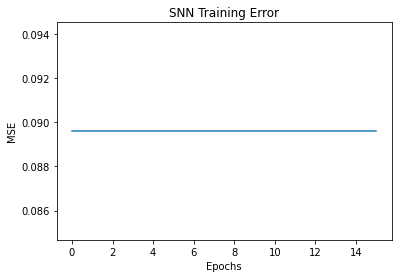

In [18]:
#print(input_params['num_samples'])
training_error = fit(samples)
plt.plot(training_error)
plt.title("SNN Training Error")
plt.xlabel('Epochs') 
plt.ylabel('MSE')      

In [23]:
# Salvando os pesos para testes de validacao
saved_enc_weights = input_params["encoding_weights"]
saved_mlp_weights = input_params["mlp_weights"]

In [24]:
input_params["mlp_current"]

array([-996.05697062, -996.05697062, -996.05697062, -996.05697062,
       -996.05697062, -996.05697062, -996.05697062, -996.05697062,
       -996.05697062, -996.05697062])

##  Etapa de Validação da Classificação da SNN. A forma que o modelo vai predizer o rótulo é baseado no cálculo de dissimilaridades entre spike trains, segundo o artigo "Monitoring spike train synchrony" (https://arxiv.org/pdf/1209.6604.pdf)

In [21]:
# Tempos do spike antecessor ao instante t
def tP(t, neuron_spike_times):
    res = neuron_spike_times[np.where(neuron_spike_times <= t)]
    if(res.shape[0] == 0):
        return 0
    else:
        return max(res)

# Tempos do spike sucessor ao instante t   
def tF(t, neuron_spike_times):
    res = neuron_spike_times[np.where(neuron_spike_times > t)]
    if(res.shape[0] == 0):
        return 0
    else:
        return min(res)
    
# Intervalo entre spikes instantaneo
def x_isi(t, neuron_spike_times):
    return tF(t, neuron_spike_times)-tP(t, neuron_spike_times)

def media_x_isi(t, spike_times):
    return 0.5*(x_isi(t, spike_times[0])+x_isi(t, spike_times[1]))

# Diferencas absolutas entre sucessores e antecessores
def delta_tP(t, spike_times):
    return abs(tP(t, spike_times[0])-tP(t, spike_times[1]))

def delta_tF(t, spike_times):
    return abs(tF(t, spike_times[0])-tF(t, spike_times[1]))

# Intervalos para os spikes antecessores e sucessores
def xP(t, neuron_spike_times):
    return t - tP(t, neuron_spike_times)

def xF(t, neuron_spike_times):
    return tF(t, neuron_spike_times) - t

def media_xp(t, spike_times):
    return 0.5*(xP(t, spike_times[0]) + xP(t, spike_times[1]))

def media_xf(t, spike_times):
    return 0.5*(xF(t, spike_times[0]) + xF(t, spike_times[1]))

# Perfil de dissimiliaridade entre os spike trains - original
def So(t, spike_times):
    numerador = (delta_tP(t, spike_times)*media_xf(t, spike_times))+(delta_tF(t, spike_times)*media_xp(t, spike_times))
    denominador = media_x_isi(t, spike_times)**2
    if (denominador == 0): denominador = 0.0001
    return numerador/denominador

# Calcula a Dissimilaridade Normalizada [0, 1] dos perfis encontrados, em funão do tempo.
def D(spike_times):
    S_original = np.zeros(input_params['lif_simulation_time'])
    for t in range(input_params['lif_simulation_time']):
        S_original[t] = So(t, spike_times)
        
    S_original_norm = (S_original-min(S_original))/(max(S_original)-min(S_original))
    return S_original_norm

# Dissimilaridade Total Media: Como estamos em tempo discreto, é apenas um somatório. Em tempo contínuo seria a integral dos perfis de dissimilaridade
def D_total (d_profile, T):
    return sum(d_profile)/(2*T)

def print_spikes_diss(spikes, diss, label):
    # plot
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 10))
    fig.suptitle('Comparando Spikes para o label {}'.format(label), fontsize=16)
    ax1.set_ylabel("Desired Spikes")
    ax1.step(range(input_params['lif_simulation_time']), spikes[0], linewidth=2.0)

    ax2.set_ylabel("Output Spikes")
    ax2.step(range(input_params['lif_simulation_time']), spikes[1], linewidth=2.0)

    ax3.set_ylabel("Dissimilaridade entre Desired e Output")
    ax3.plot(range(input_params['lif_simulation_time']), diss, linewidth=2.0)

    plt.show()

In [22]:
def spike_affinity(model_times=None, desired_times=None, model_spikes=None, desired_spikes=None, print_debug_label=-1):
    diss_vec = np.zeros(input_params['num_classes'])
    for label in range(input_params['num_classes']):
        times = np.asarray([desired_times[label],model_times[label]])
        diss_profile = D([desired_times[label],model_times[label]])
        if(print_debug_label > -1):
            spikes = np.asarray([desired_spikes[print_debug_label],model_spikes[print_debug_label]])
            print_spikes_diss(spikes, diss_profile, print_debug_label)
            print_debug_label = -1
        diss_vec[label] = D_total(diss_profile, input_params['lif_simulation_time'])
    #print(diss_vec)
    return np.argmin(diss_vec)

def predict_label(target_label=None, target_sample=None, print_spikes_diss=-1):
    output_spikes, _, output_times, _, _ = map(samples[target_label][target_sample], 
                                                        saved_enc_weights,
                                                        saved_mlp_weights)
    
    label_affinity = spike_affinity(output_times, 
                                    input_params['desired_times'],
                                    output_spikes, 
                                    input_params['desired_spikes'], 
                                    print_debug_label = print_spikes_diss)

    return label_affinity

def eval_accuracy():
    acc = np.zeros(input_params['num_classes'])
    for label in range(input_params['num_classes']):
        num_acertos = 0
        for sample in range(input_params['num_samples']):
          #print("Sample {}, Label {}".format(sample, label))
          predicted_label = predict_label(label, sample)
          #print('Rótulo Esperado: {} // Rótulo Predito: {}'.format(label, predicted_label))
          if(label == predicted_label): 
              num_acertos += 1
        acc[label] = num_acertos/input_params['num_samples']
        print("Acurácia para o rótulo {}: {}".format(label, round(100*(acc[label]),2)))
    return acc

def run_epoch_experiment(epochs_list):
    epoch_cols = []
    acc_list = []
    
    for epoch in range(len(epochs_list)):
        #print('Usando {} épocas'.format(epochs_list[epoch]))
        input_params['num_epochs'] = epochs_list[epoch]
        epoch_cols.append('Época_'+str(epochs_list[epoch]))
        fit(samples)
        acc = eval_accuracy()
        acc_list.append(acc)

    return np.asarray(acc_list)

def unit_epoch_exp(epoch):
    input_params['num_epochs'] = epoch
    fit(samples)
    acc = eval_accuracy()
    return acc